In [10]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

$k$-means is a mathematically straightforward but computationally intensive hard-clustering method for grouping data into clusters of similar data points with similar variances.  It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia.  If you recall the lesson on linear regression, the formula for inertia may be familiar:

$$\sum(\bar{x}_c - x_i)^2$$

In words, the inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

So the *means* in $k$-means refers to the centroids.  The $k$ is the number of centroids (and thus, the number of clusters) the algorithm works with, which is provided by the user.  It's a pretty literal name.

How do you pick $k$?  Basically through trial and error.   Pick a $k$, look at the solution, see if it makes sense, then try other $k$'s.  Clusters representing "real" divisions in the data will be stable across training set and test set.

## How the algorithm works

$k$-means is an iterative algorithm that eventually converges on a solution.  It begins by choosing $k$ centroids at random, then repeats the following two steps until convergence:

1. Assign each data point to the nearest centroid
2. Create new centroids by taking the mean of all the data points assigned to each centroid

The algorithm stops when the difference between the old and new centroids is lower than a given threshold.

Like other iterative algorithms with a random start, bad starting centroid values can cause $k$-means to arrive at a lousy solution.  As a result, it is recommended to try the algorithm a few times with different starting centroids.  The sklearn implementation has a nifty `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.


## Assumptions made by $k$-means models

$k$-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward.  It also assumes all clusters have similar variances.  See these [pictures of clusters](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) that do and do not fit the $k$-means isotropic and variance assumptions.  

## Speed

High-dimensional data tends to make $k$-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration.  The loop steps are similar to those in the original:

 1. Assign the samples to their nearest centroids.
 2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular $k$-means but drastically faster.

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

In [16]:
df.shape

(1000, 3)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

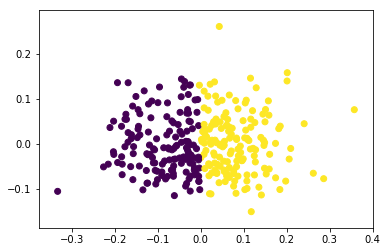

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [14]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
#Robin: c = is a color parameter
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [18]:
X_pca.shape

(303, 2)

In [37]:
np.sum(y) / X_pca.shape[0]

0.54125412541254125

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [15]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

predict_mini = minibatchkmeans.predict(X_pca)

# Check the solution against the data.
print('Comparing mini-batch clusters against the data:')
print(pd.crosstab(predict_mini, y))

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing mini-batch clusters against the data:
col_0   0   1
row_0        
0      90  72
1      49  92
Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0      149   13
1        0  141


#### **** Question/comment

Reading the comparison crosstab: 141 = (49 + 92), the 1 row for minibatch.  149 = (84 + 65) or the 0 row for k-means. No clue what the 13 or 0 represent. There are 303 rows in the dataset. 

#### I don't understand how this illustrates that there is 'better' clustering using one method vs the other.

From the pandas crosstab documentation: pd.crosstab(crosstab_index, crosstab_columns). i.e., first parameter is the row label, second is the column.

#### ****

This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.

## Robin's Work

Your task is to take the k-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

#### Timing: Try re-running the  𝑘 -means and mini batch  𝑘 -means models and timing their execution using the reduced feature set defined by pca. 

In [3]:
import time

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)


In [6]:
%%timeit

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

24.9 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit

minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

13.3 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Timing observation: Minibatch k-means runs in 53% of the time it takes a full K-means to run.

Regarding minibatch k-means, "The larger the size of the batch, the more computationally costly the training process." 

Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (p. 291). O'Reilly Media. Kindle Edition. 

#### What happens when I change the value of  𝑘?

In [20]:
from sklearn import metrics

In [44]:
# Change k to 3 - k means

y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)


# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

print('Silhouette score:')
print(metrics.silhouette_score(X_pca, y_pred))

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      65  70
1      25  61
2      49  33
Silhouette score:
0.315544294434


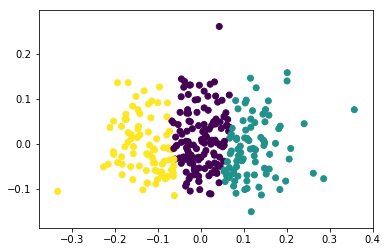

In [46]:
# Plot the 3-cluster solution.
#Robin: c = is a color parameter
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [45]:
#Try 3 clusters using the minibatch model

minibatchkmeans = MiniBatchKMeans(
    init='random',
    random_state = 42,
    n_clusters=3,
    batch_size=200)

minibatchkmeans.fit(X_pca)

predict_mini = minibatchkmeans.predict(X_pca)

# Check the solution against the data.
print('Comparing mini-batch clusters against the data:')
print(pd.crosstab(predict_mini, y))

print('Silhouette score:')
print(metrics.silhouette_score(X_pca, predict_mini))

Comparing mini-batch clusters against the data:
col_0   0   1
row_0        
0      51  34
1      63  71
2      25  59
Silhouette score:
0.314112644922


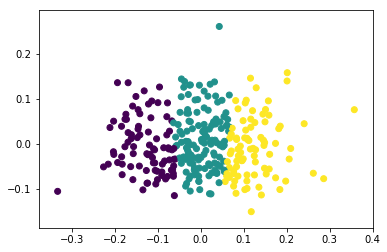

In [47]:
# Plot the 3-cluster solution.
#Robin: c = is a color parameter
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = predict_mini)
plt.show()

In [48]:
X_pca_4 = PCA(4).fit_transform(X_norm)

In [55]:
minibatchkmeans = MiniBatchKMeans(
    init='random',
    random_state = 42,
    n_clusters=2,
    batch_size=200)

minibatchkmeans.fit(X_pca_4)

predict_mini = minibatchkmeans.predict(X_pca_4)

# Check the solution against the data.
print('Comparing mini-batch clusters against the data:')
print(pd.crosstab(predict_mini, y))

print('Silhouette score:')
print(metrics.silhouette_score(X_pca_4, predict_mini))

Comparing mini-batch clusters against the data:
col_0   0    1
row_0         
0      81   58
1      58  106
Silhouette score:
0.36493704615


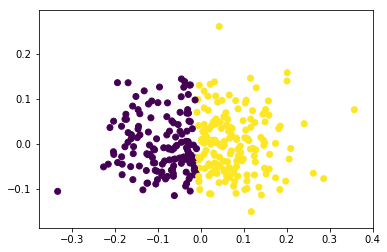

In [57]:
# Plot the 2-cluster solution using 4 feature vectors
#Robin: c = is a color parameter
plt.scatter(X_pca_4[:, 0], X_pca_4[:, 1], c = predict_mini)
plt.show()

### Discussion

#### Example use case for clustering

For example, imagine we have records of sales from a grocery store and we want to break up sales by whether or not the shopper is a member of a discount club. This would be impossible using supervised learning because we don’t have a target to train and evaluate our models. However, there is another option: unsupervised learning. If the behavior of discount club members and nonmembers in the grocery store is actually disparate, then the average difference in behavior between two members will be smaller than the average difference in behavior between a member and nonmember shopper. Put another way, there will be two clusters of observations.

Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (p. 287). O'Reilly Media. Kindle Edition. 

#### Learning about k-means assumptions and requirements

It is important to note three things about k-means. First, k-means clustering assumes the clusters are convex shaped (e.g., a circle, a sphere). Second, all features are equally scaled... Third, the groups are balanced (i.e., have roughly the same number of observations). If we suspect that we cannot meet these assumptions, we might try other clustering approaches.

Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (pp. 288-289). O'Reilly Media. Kindle Edition. 

#### Learning about feature scaling

http://benalexkeen.com/feature-scaling-with-scikit-learn/

StandardScaler is not the best to use if the data is not normally distributed. An example in the machine learning cookbook does use StandardScaler, but it is not a good choice for this problem.

"One of the key differences between scaling (e.g. standardizing) and normalizing, is that normalizing is a row-wise operation, while scaling is a column-wise operation." 

"Scaling inputs to unit norms is a common operation for text classification or clustering." This means, use Normalize or Normalizer. (https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9)

Normalize (as opposed to Normalizer) "...Scale[s] input vectors individually to unit norm (vector length)." It's default is the l2 method. After PCA we have vectors, so normalize (rather than Normalizer) is appropriate.

A good visual example of Normalizer. The default is the l2 method, which is shown below.

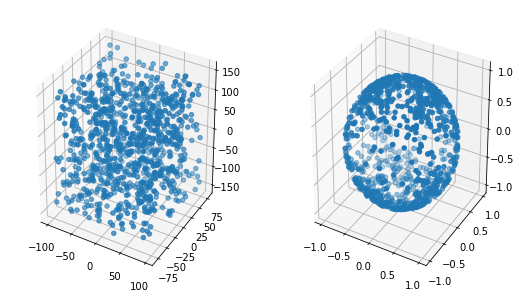

In [12]:
from mpl_toolkits.mplot3d import Axes3D

df = pd.DataFrame({
    'x1': np.random.randint(-100, 100, 1000).astype(float),
    'y1': np.random.randint(-80, 80, 1000).astype(float),
    'z1': np.random.randint(-150, 150, 1000).astype(float),
})

scaler = Normalizer()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(df['x1'], df['y1'], df['z1'])
ax2.scatter(scaled_df['x1'], scaled_df['y1'], scaled_df['z1'])
plt.show()

#### Choosing k, the number of clusters

"One way of determining the reasonable number of clusters is based on the concept of prediction strength." This method uses test and training sets and compares how consistent the clustering results are between the training and test data.

"Another effective method to estimate the number of clusters is the gap statistic method. Other, less automatic methods, which some analysts still use, include the elbow method and the average silhouette method."

Andriiy Burkov, The Hundred Page Machine Learning Book, p 112

#### Evaluating the effectiveness of the model

If possible, begin by using t-SNE or other tool that can handle multiple dimensions to project the clusters in lower dimensions. Inspect the clusters visually.

For example, silhouette coefficients ... measure the similarity within clusters compared with the similarity between clusters.

Albon, Chris. Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning (p. 289). O'Reilly Media. Kindle Edition. 

The silhouette coefficients can be graphed even if the data has too many dimensions to graph. You may see a point at which the graph drops off; that point would be a good k. 

#### Using k-Means cluster model results in real world applications

The idea is to identify the characteristics in the data that define each cluster (either explicitly or implicitly). You may decide that one cluster represents a population that you want to target or further investigate. Then you can use the model to classify new data into the defined clusters, or query for data that matches the characteristics of the defined cluster. Or, once you've defined data as being part of a specific cluster, you could then code that data with the cluster identifier and track some attribute (like buying behavior) going forward.

k-Means clustering can be used in a preliminary step for a supervised learning problem by using the distance-to-centroid as a feature. https://stackoverflow.com/questions/25012342/scikit-learns-k-means-what-does-the-predict-method-really-do

### Findings and further questions

"Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example."

I do not understand how to determine if "...complexity starts to become an issue" with this dataset.

I would like to understand the interplay between the number of features and the number of clusters. I don't understand why Thinkful chose to limit this problem to 2 features using PCA, unless it is to keep runtime low.

Using 4 rather than 2 feature vectors and 2 clusters leads to a slightly higher silhouette score though the clusters don't appear to be any more compact when graphed.

Using 3 clusters rather than 2 does not lead to visibly more compact clusters or to a higher silhouette score.

Using 4 clusters with 2 feature vectors did not lead to better results, either.

From this I might conclude that there is more going on in the data than we are able to capture in 2, 3 or 4 clusters. Perhaps using more features and/or not using PCA for feature reduction would allow better differentiation of clusters, but I could also end up with clusters that are too tightly defined and not useful.